## In this kernel you will learn how to implement LightGBM + Kfold technique which results in higher score!

**LightGBM** is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel and GPU learning.
* Capable of handling large-scale data.

You can read full documentation [here](https://lightgbm.readthedocs.io/en/latest/)

# here, imagine some cool picture about dota2)

### Now, let's import all required packages 

In [1]:
import os #to access files
import pandas as pd #to work with dataframes
import numpy as np #just a tradition
from sklearn.model_selection import StratifiedKFold #for cross-validation
from sklearn.metrics import roc_auc_score #this is we are trying to increase
import matplotlib.pyplot as plt #we will plot something at the end)
import seaborn as sns #same reason
import lightgbm as lgb #the model we gonna use

## Let's read the data: train, target and test

In [2]:
%%time
PATH_TO_DATA = '../data/'

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'train_features.csv'), 
                                    index_col='match_id_hash')
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_features.csv'), 
                                   index_col='match_id_hash')

CPU times: total: 766 ms
Wall time: 886 ms


## Lets have a look what are these data look like:

In [3]:
df_train_features.head(2)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,0.0,0,0,0,0,0.0,0,0,0,0
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.0,0,0,0,0,0.0,0,0,0,0


In [5]:
df_train_targets.head(2)

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,False,992,837,NaN
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN


In [6]:
df_test_features.head(2)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
30cc2d778dca82f2edb568ce9b585caa,23,4,0,0,0,79,0,0,0,0,...,0.00000,0,0,1,0,0.000000,0,0,0,0
70e5ba30f367cea48793b9003fab9d38,1044,22,7,12,6,23,3,5,7,1,...,67.02582,2,1,4,0,0.833333,0,0,5,2


I have no idea what these features mean...I prefer FIFA)

In [7]:
#turn to X and y notations for train data and target
X = df_train_features.values
y = df_train_targets['radiant_win'].values #extract the colomn we need

In [8]:
#this is to make sure we have "ujson" and "tqdm"
#尝试导入上述两个库
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ('Please install ujson to read JSON oblects faster')
    
try:
    from tqdm import tqdm_notebook
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ('Please install tqdm to track progress with Python loops')

In [10]:
#a helper function, we will use it in next cell
#一个函数，用于读取 matches_file（.jsonl 文件）并用进度条显示
#可以分类讨论读取test_matches.jsonl和train_matches.jsonl两个文件

def read_matches(matches_file):
    
    #一个字典，每种文件的条目数
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000, 
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)
            #逐行读取文件，并将每行的 JSON 数据解析为 Python 字典格式，通过 yield 返回每一条记录。
            #yield 使得该函数成为生成器，按需返回数据，避免一次性读取大文件占用过多内存。

Now, we define a function which adds some new features:

PS: all of these are from "how to start" kernel by @yorko

In [12]:
#函数，在读入的jsonl文件中，生成新的特征列

def add_new_features(df_features, matches_file):
    
    # Process raw data and add new features
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']#对jsonl文件的每一行

        # Counting ruined towers for both teams
        #构建两个新的特征，构造他们的值
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match['objectives']:
            if objective['type'] == 'CHAT_MESSAGE_TOWER_KILL':
                if objective['team'] == 2:
                    radiant_tower_kills += 1
                if objective['team'] == 3:
                    dire_tower_kills += 1

        # Write new features
        #将三个新的特征写入新的列
        df_features.loc[match_id_hash, 'radiant_tower_kills'] = radiant_tower_kills
        df_features.loc[match_id_hash, 'dire_tower_kills'] = dire_tower_kills
        df_features.loc[match_id_hash, 'diff_tower_kills'] = radiant_tower_kills - dire_tower_kills
        
        #let's add one more
        df_features.loc[match_id_hash, 'ratio_tower_kills'] = radiant_tower_kills / (0.01+dire_tower_kills)
        # ... here you can add more features ...
        

In [13]:
%%time

#对训练集和测试集的特征文件，根据特征拓展函数，进行特征拓展操作

# copy the dataframe with features
df_train_features_extended = df_train_features.copy()
df_test_features_extended = df_test_features.copy()

# add new features
add_new_features(df_train_features_extended, os.path.join(PATH_TO_DATA, 'train_matches.jsonl'))
add_new_features(df_test_features_extended, os.path.join(PATH_TO_DATA, 'test_matches.jsonl'))

C:\Users\DELL\AppData\Local\Temp\ipykernel_6020\1870397398.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin, total=total_matches):


  0%|          | 0/39675 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_6020\1870397398.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm_notebook(fin, total=total_matches):


  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: total: 35 s
Wall time: 49.4 s


In [14]:
#Just a shorter names for data
newtrain=df_train_features_extended #train集的X
newtest=df_test_features_extended #test集的X
target=pd.DataFrame(y) #用来监督的train集的标签，实际意义为胜率

In [15]:
#lastly, check the shapes, Andrew Ng approved)
newtrain.shape,target.shape, newtest.shape

((39675, 249), (39675, 1), (10000, 249))

After running the LightGBM model, we will visualize something called "feature importance", which  kind of shows which features and how much they affected the final result. For this reason we need to store feature names:

In [16]:
#存储各个特征列名称，以便后续可视化展示个特征重要性
features=newtrain.columns

## Noow, let's define LightGBM parameters. 

在前面完成了在csv文件中的数据读取操作；

jsonl文件中的数据读取函数设计，新增特征函数设计

并且对训练集和测试集的特征文件进行了特征拓展操作，作为新的训练集的X,y和测试集的X。。

完成上述数据准备工作，现在可以进行模型的参数设计。

Personally, I understand only some of these parameters. So, these are some random set up. Maybe it is better to look up the official documentation. Tuning these parameters definitely will increase your score.

Investigation in process...

In [17]:
'''
param = {
        'bagging_freq': 5,  #handling overfitting 每隔五轮从训练集中采样一次
        'bagging_fraction': 0.5,  #handling overfitting - adding some noise 每次只采样50%来训练
        'boost_from_average':'false', #如果设置为 true，则提升树会以目标值的平均值为基准。通常在分类问题中可能关闭此选项
        'boost': 'gbdt', #梯度提升决策树算法
        'feature_fraction': 0.05, #handling overfitting
        'learning_rate': 0.01,  #the changes between one auc and a better one gets really small thus a small learning rate performs better
        'max_depth': -1,  
        'metric':'auc',
        'min_data_in_leaf': 50,
        'min_sum_hessian_in_leaf': 10.0,
        'num_leaves': 10,
        'num_threads': 5,
        'tree_learner': 'serial', 
        'objective': 'binary', 
        'verbosity': 1
    }
'''


param = {
    'boosting_type' : 'gbdt', #梯度提升决策树，一种利用残差的多决策树集成学习
    'objective' : 'binary', #二分类
    'metric' : 'auc', #模型评估指标
    #'num_iterations' : 100, #生成多少棵树，即追逐残差多少次
    'learning_rate': 0.01,
    #下面有控制决策树叶子结点最多最少，深度最多最少的参数，均采用default
    'num_leaves' : 31, #最大叶子结点数
    'max_depth' : -1, #不限制最大参数
    'min_data_in_leaf' : 20, #一个叶子结点中最小的样本量，防止过度细的分类而过拟合
    'feature_fraction' : 0.9, #每次构建树时用于选择的特征的比例，不选择1防止过拟合
    'bagging_fraction' : 0.8, #每次迭代时用于训练的数据的比例，不选择1(全部样本)防止过拟合
    'verbosity': 1 #控制训练过程中的输出级别，表示要输出信息
}


# Finally, let's run the model

In [18]:
%%time
#divide training data into train and validaton folds
#folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=17) #不打乱数据顺序 5折划分
folds = StratifiedKFold(n_splits=5, shuffle=False)

#placeholder for out-of-fold, i.e. validation scores
#初始化结果的占位符
oof = np.zeros(len(newtrain))#39675 承接 在初始训练集上的预测的结果 的容器

#for predictions
predictions = np.zeros(len(newtest))#10000 承接在初始测试集上的预测结果的容器

#and for feature importance
feature_importance_df = pd.DataFrame() #每个特征的重要性

#RUN THE LOOP OVER FOLDS
for fold_, (trn_idx, val_idx) in enumerate(folds.split(newtrain.values, target.values)):#划分训练集的X和y，选其中4折作为新训练集，1折作为新测试集
    #trn_idx, val_idx ：划分为训练集和测试集的样本行数索引
    
    X_train, y_train = newtrain.iloc[trn_idx], target.iloc[trn_idx]
    X_valid, y_valid = newtrain.iloc[val_idx], target.iloc[val_idx]
    
    print("Computing Fold {}".format(fold_))
    #把原先的训练集new_train进一步五折划分为训练集和测试集，以便交叉训练
    trn_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_valid, label=y_valid)

    
    num_round = 5000 
    verbose=1000 
    stop=500 
    
    # 使用回调函数实现 early_stopping 和控制日志输出
    callbacks = [
        lgb.early_stopping(stopping_rounds=stop),  # 500轮内验证集性能指标无明显改善，则终止训练
        lgb.log_evaluation(period=verbose)  # 每隔多少轮输出一下训练日志
    ]

    #TRAIN THE MODEL
    clf = lgb.train(param, trn_data, 
                    num_round, #最大迭代轮次
                    valid_sets = [trn_data, val_data], #训练集和验证集一起作为验证
                    valid_names=['train', 'valid'],  # 添加验证集名称
                    callbacks=callbacks  # 使用回调函数实现功能
                    )
    
    #CALCULATE PREDICTION FOR VALIDATION SET
    #在5折划分中，验证集的那一折上面，用训练好的模型预测
    oof[val_idx] = clf.predict(newtrain.iloc[val_idx], num_iteration=clf.best_iteration)
    
    #FEATURE IMPORTANCE
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()#根据特征被用于分割节点的次数计算各属性重要性
    fold_importance_df["fold"] = fold_ + 1 #记录本次是第几轮得到的重要性
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0) #将本次得到的各属性重要性与之前的作一个表格拼接
    #最终得到一个三列的表格：属性|重要性|第几折得到的这个重要性
    
    #CALCULATE PREDICTIONS FOR TEST DATA, using best_iteration on the fold
    predictions += clf.predict(newtest, num_iteration=clf.best_iteration) / folds.n_splits

#print overall cross-validatino score
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Computing Fold 0
[LightGBM] [Info] Number of positive: 16661, number of negative: 15079
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26883
[LightGBM] [Info] Number of data points in the train set: 31740, number of used features: 249
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.524921 -> initscore=0.099768
[LightGBM] [Info] Start training from score 0.099768
Training until validation scores don't improve for 500 rounds
[1000]	train's auc: 0.899552	valid's auc: 0.811022
[2000]	train's auc: 0.956146	valid's auc: 0.813895
[3000]	train's auc: 0.982967	valid's auc: 0.815087
[4000]	train's auc: 0.994185	valid's auc: 0.81594
[5000]	train's auc: 0.998385	valid's auc: 0.816809
Did not meet early stopping. Best iteration is:
[4922]	train's auc: 0.99821	valid's auc: 0.816837
Computing Fold 1
[LightGBM] [Info] Number of positive: 16661, number of neg

## Feature Importance

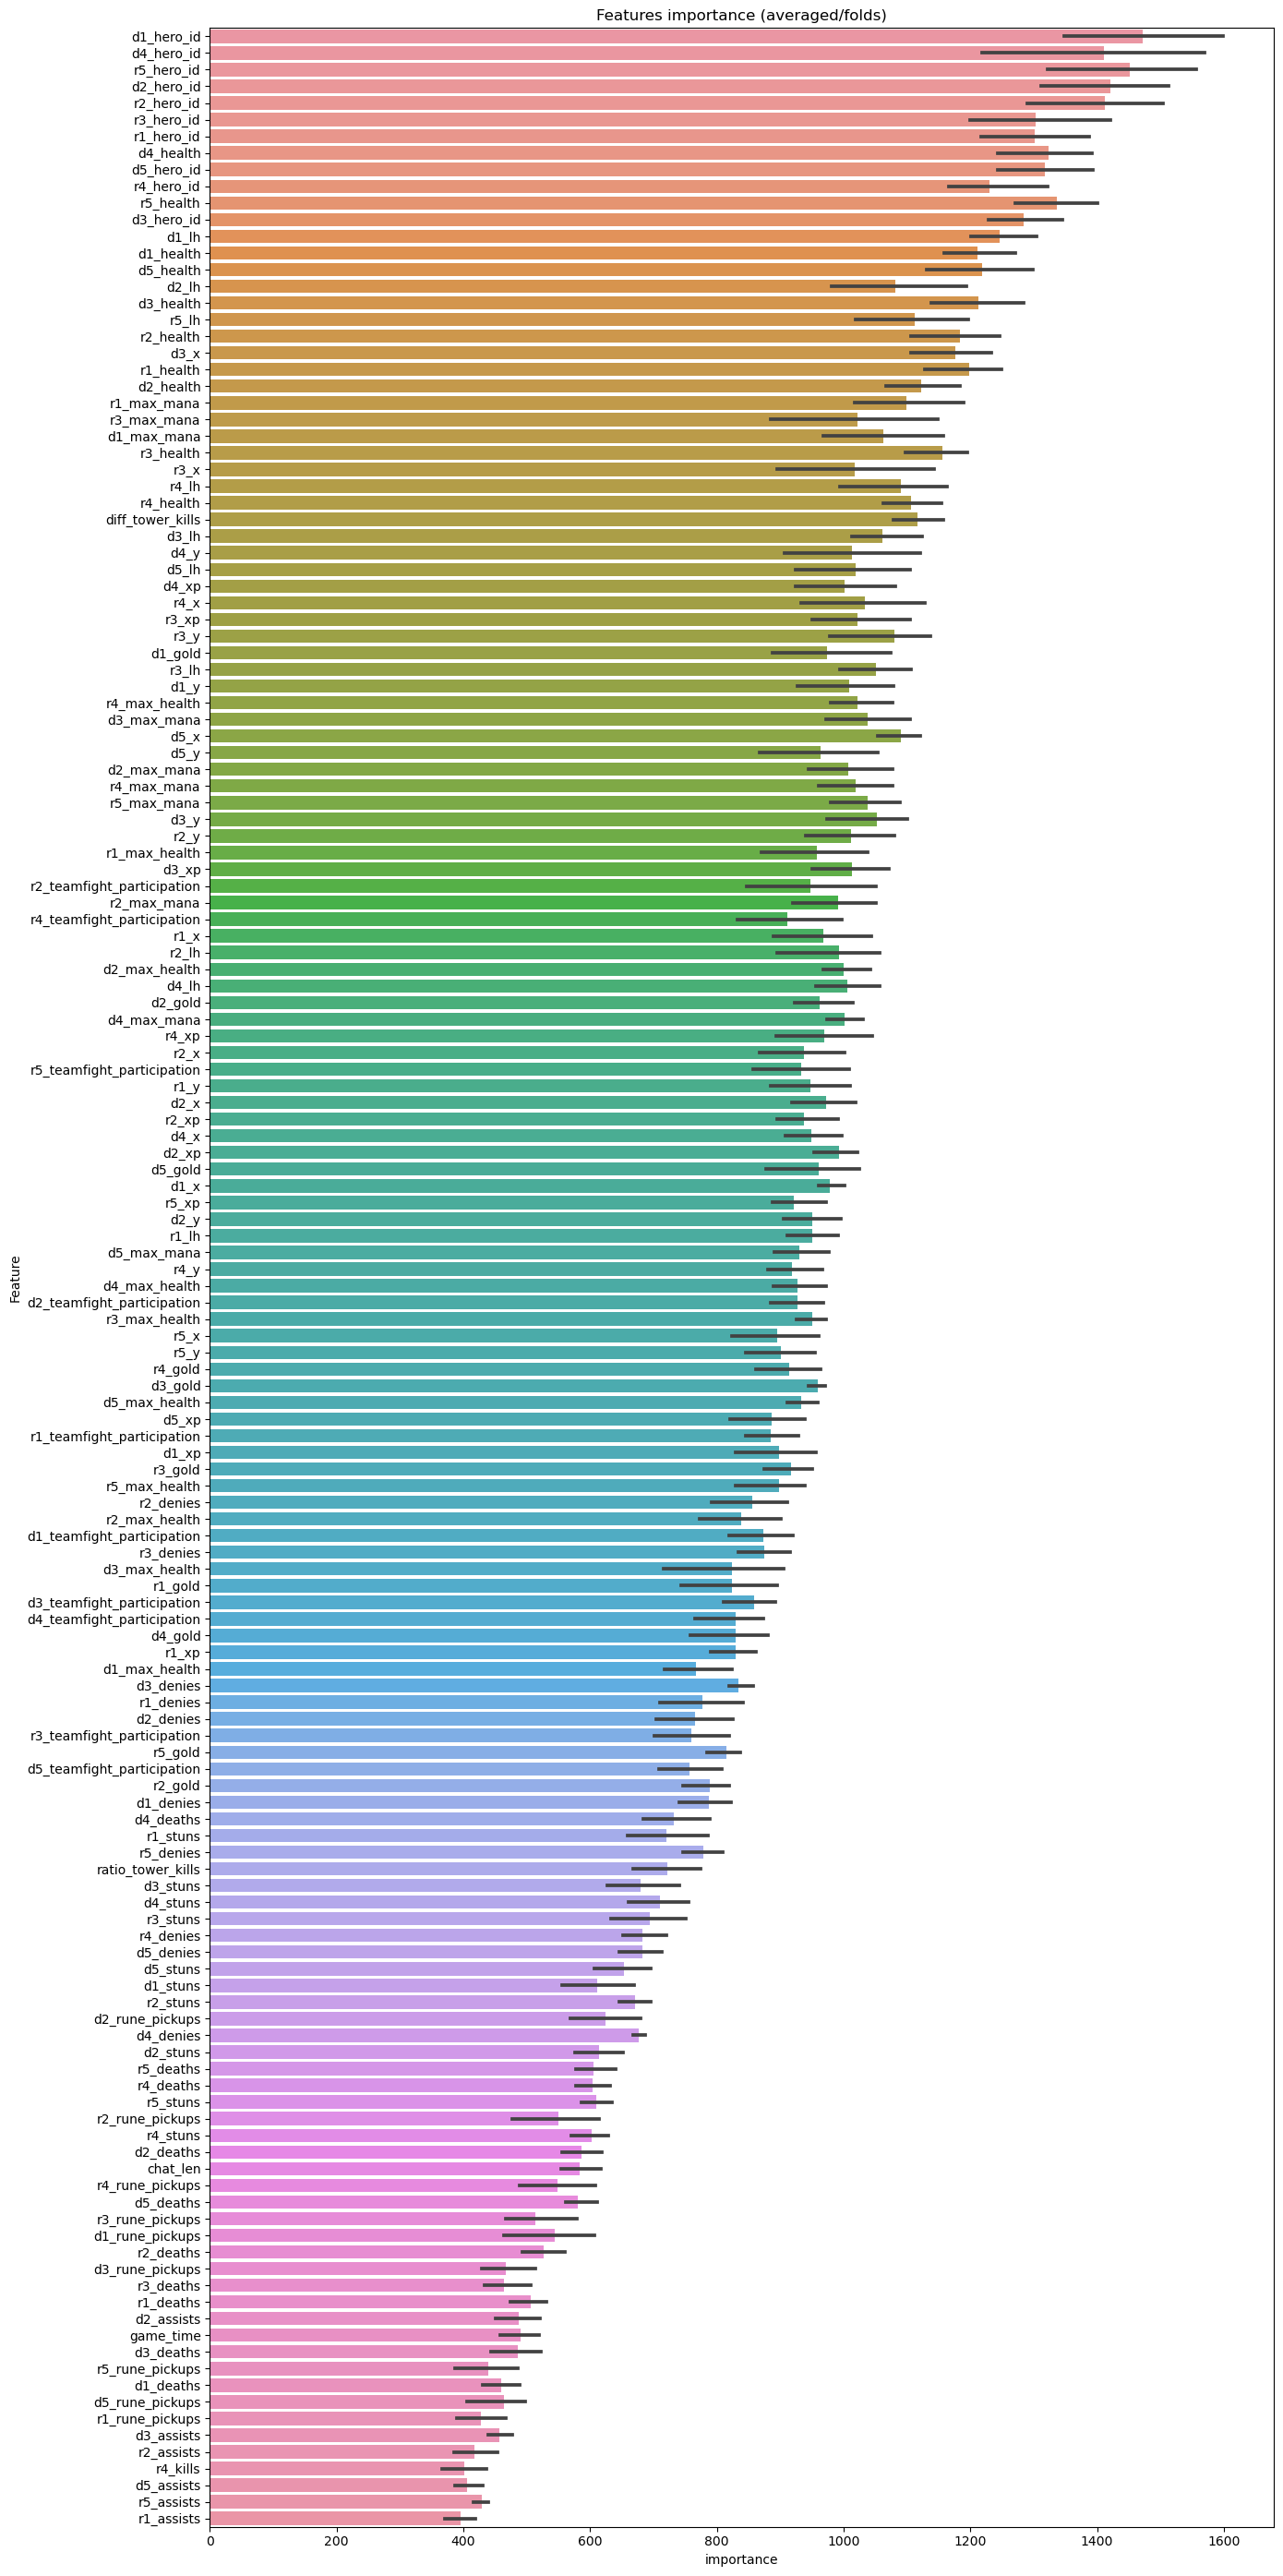

In [83]:
# 计算每个特征在所有折中的平均重要性，并按重要性降序排列，选择前150个特征的索引

cols = (feature_importance_df[["Feature", "importance"]] #选取关心的两列
        .groupby("Feature") #一个groupby
        .mean() #取平均
        .sort_values(by="importance", ascending=False)[:150].index)
# 在所有特征中，筛选出属于前150个特征的行，存储为 best_features
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

From these feature importance chart, we can see that some features play significant role in making the prediction than others. Maybe dropping out less affecting features is a good idea. But still need more investigation of dota2 features...

## Prepare submission file

In [17]:
df_submission = pd.DataFrame({'radiant_win_prob': predictions}, 
                                 index=df_test_features.index)
import datetime
submission_filename = 'submission_{}.csv'.format(
    datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
df_submission.to_csv(submission_filename)
print('Submission saved to {}'.format(submission_filename))

Submission saved to submission_2019-04-02_19-38-49.csv


# What's next?

* try to tune parameters, it will definitely improve your LB score
* try to come up with good features
* read other kernels
* try other models as well

### Hopefully, this kernel was usefull. Feel free to fork, comment and upvote!